In [1]:
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
import os

class NotebookOscillator:
    def __init__(self, **kwards):
        self.simulator_path = "./oscillator_simulator"
        self.config = {
            "initial_position": 10.0,
            "initial_velocity": 0.0,
            "dt": 0.001,
            "w": 10.0,
            "gamma": 1.0,
            "omega": 10.0,
            "A": 1.0,
            "simulation_time": 50.0,
            "output_file": "results.csv",
            "method": "RK4",
            "equation": "MathPendulum"
        }
        self.set_parameters(**kwards)
        self.results = None
    
    def compile_simulator(self):
        result = subprocess.run([
            "g++", "-std=c++17", "-O3", "oscillator.cpp", 
            "-o", self.simulator_path
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симулятор успешно скомпилирован!"))
            return True
        else:
            display(Markdown("Ошибка компиляции:"))
            print(result.stderr)
            return False
    
    def set_parameters(self, **kwargs):
        for key, value in kwargs.items():
            if key in self.config:
                self.config[key] = value
    
    def show_parameters(self):
        display(Markdown("Текущие параметры симуляции"))
        params_df = pd.DataFrame([self.config])
        display(params_df)
    
    def run_simulation(self, config_file="config.json"):
        # Проверяем наличие симулятора
        if not os.path.exists(self.simulator_path):
            if not self.compile_simulator():
                return False
        
        # Сохраняем конфигурацию
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)
                
        # Запускаем симуляцию
        result = subprocess.run([
            self.simulator_path, config_file
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            display(Markdown("Симуляция завершена успешно!"))
            output_file = self.config["output_file"]
            df = pd.read_csv(output_file)
            self.results = df
            return True
        else:
            display(Markdown("Ошибка симуляции:"))
            print(result.stderr)
            return False
        
    
    def plot_results(self):                
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Положение от времени
        ax1.plot(self.results['time'], self.results['position'], 'b-', linewidth=2, label= self.config['method'])
        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Скорость от времени
        ax2.plot(self.results['time'], self.results['velocity'], 'r-', linewidth=2, label= self.config['method'])
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Фазовый портрет
        ax3.plot(self.results['position'], self.results['velocity'], 'g-', linewidth=1, label= self.config['method'])
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # Энергия
        ax4.plot(self.results['time'], self.results['energy'], 'purple', linewidth=2, label= self.config['method'])
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

    def theory_solution(self):
        w = self.config['w']
        gamma = self.config['gamma']
        dt = self.config['dt']
        simulation_time = self.config['simulation_time']
        
        n = int(simulation_time / dt)
        t = np.linspace(0, simulation_time, n)
        
        x = np.zeros(n)
        v = np.zeros(n)
        x_0 = self.config['initial_position']
        v_0 = self.config['initial_velocity']
        
        lambda_1 = 0.5 * (-gamma + np.sqrt(gamma*gamma - 4*w*w))
        lambda_2 = 0.5 * (-gamma - np.sqrt(gamma*gamma - 4*w*w))

        if gamma > 2*w:  # Перезатухание
            for i in range(n):
                c_1 = (v_0 - x_0*lambda_2) / (lambda_1 - lambda_2)
                c_2 = (x_0*lambda_1 - v_0) / (lambda_1 - lambda_2)
                x[i] = c_1*np.exp(lambda_1*t[i]) + c_2*np.exp(lambda_2*t[i])
                v[i] = c_1*lambda_1*np.exp(lambda_1*t[i]) + c_2*lambda_2*np.exp(lambda_2*t[i])
                
        elif gamma == 2*w:  # Критическое затухание
            for i in range(n):
                c_1 = x_0
                c_2 = v_0 + gamma/2 * x_0
                x[i] = (c_1 + c_2*t[i]) * np.exp(-gamma/2 * t[i])
                v[i] = (c_2 * (1 - gamma/2 * t[i]) - c_1 * gamma/2) * np.exp(-gamma/2 * t[i])
                
        else:  # Колебательный случай (γ < 2w)
            beta = np.sqrt(4*w*w - gamma*gamma) / 2
            for i in range(n):
                c_1 = x_0
                c_2 = (v_0 + gamma/2 * x_0) / beta
                x[i] = np.exp(-gamma/2 * t[i]) * (c_1*np.cos(beta*t[i]) + c_2*np.sin(beta*t[i]))
                v[i] = np.exp(-gamma/2 * t[i]) * (
                    -gamma/2 * (c_1*np.cos(beta*t[i]) + c_2*np.sin(beta*t[i])) +
                    beta * (-c_1*np.sin(beta*t[i]) + c_2*np.cos(beta*t[i]))
                )
        
        E = v**2/2 + w*w*x**2/2
        return x, v, E, t
        
        
    def compare_methods(self):
        methods = ["RK4", "Euler", "Hoina"]
        colors = ['g', 'r', 'b']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        for i in range(len(methods)):
            self.set_parameters(method=methods[i], output_file=methods[i]+"Results.csv")
            self.run_simulation()

            ax1.plot(self.results['time'], self.results['position'], color=colors[i], linewidth=1, label=methods[i])
            ax2.plot(self.results['time'], self.results['velocity'], color=colors[i], linewidth=1, label=methods[i])
            ax3.plot(self.results['position'], self.results['velocity'], color=colors[i], linewidth=1, label=methods[i])
            ax4.plot(self.results['time'], self.results['energy'], color=colors[i], linewidth=1, label=methods[i])
        
        x_theory, v_theory, E_theory, t_theory = self.theory_solution()
        
        ax1.plot(t_theory, x_theory, color='orange', linewidth=1, label="theory solve")
        ax2.plot(t_theory, v_theory, color='orange', linewidth=1, label="theory solve")
        ax3.plot(x_theory, v_theory, color='orange', linewidth=1, label="theory solve")  # ИСПРАВЛЕНИЕ: x_theory vs v_theory
        ax4.plot(t_theory, E_theory, color='orange', linewidth=1, label="theory solve")

        ax1.set_xlabel('Время (с)')
        ax1.set_ylabel('Положение')
        ax1.legend()
        ax1.set_title('Положение от времени')
        ax1.grid(True, alpha=0.3)
        
        ax2.set_xlabel('Время (с)')
        ax2.set_ylabel('Скорость')
        ax2.set_title('Скорость от времени')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3.set_xlabel('Положение')
        ax3.set_ylabel('Скорость')
        ax3.set_title('Фазовый портрет')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        ax4.set_xlabel('Время (с)')
        ax4.set_ylabel('Энергия')
        ax4.set_title('Сохранение энергии')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

        plt.tight_layout()
        plt.show()

In [15]:
sim = NotebookOscillator()
sim.compile_simulator()

Симулятор успешно скомпилирован!

True

In [26]:
sim.set_parameters(
    initial_position=100.0,
    initial_velocity=100.0,
    w=1.0,
    gamma=0.5,
    omega=1.0,
    A=50.0,
    simulation_time=5000,
    dt=0.5,
    equation="ForcedDampedMathPendulum",
    method="RK4"
)

sim.show_parameters()

Текущие параметры симуляции

,initial_position,initial_velocity,dt,w,gamma,omega,A,simulation_time,output_file,method,equation
0,100.0,100.0,0.5,1.0,0.5,1.0,50.0,5000,results.csv,RK4,ForcedDampedMathPendulum


Симуляция завершена успешно!

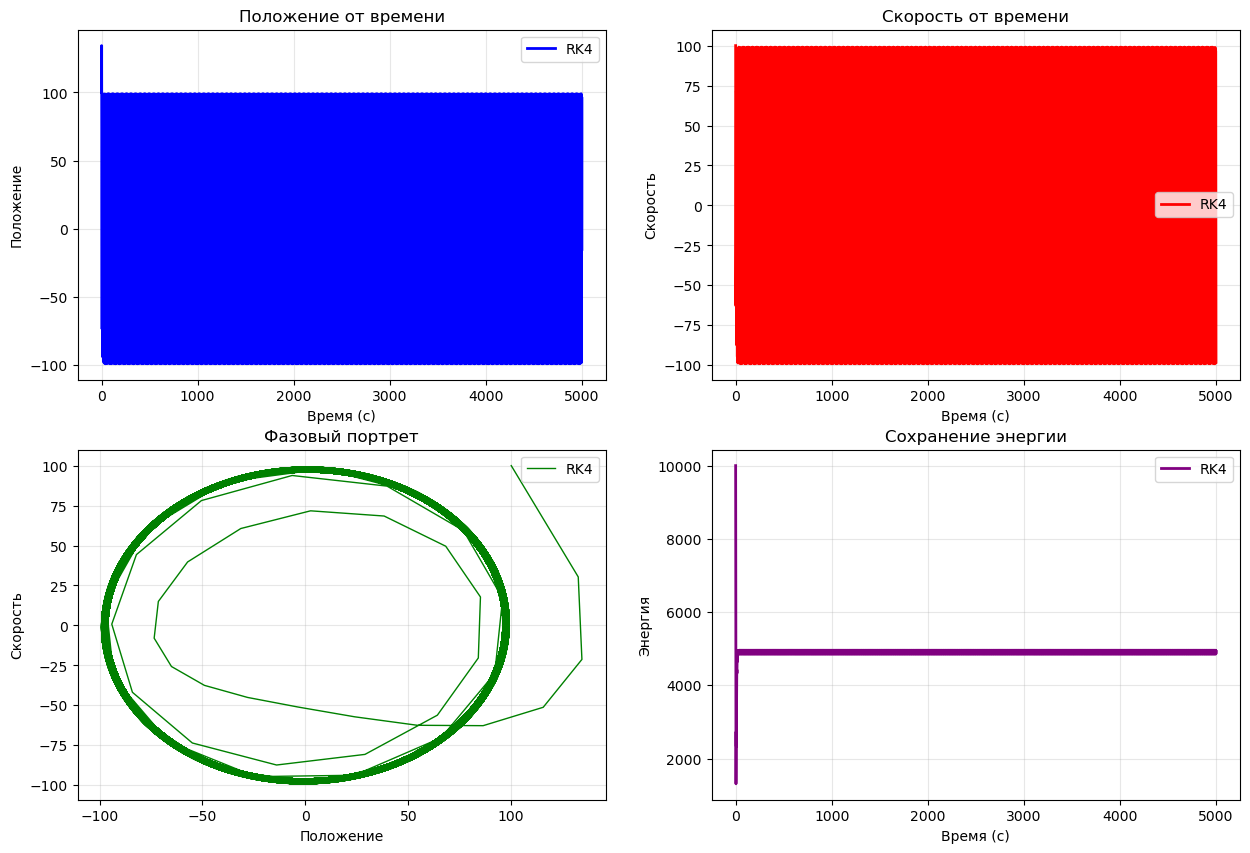

In [28]:
sim.run_simulation()   
sim.plot_results()

Симуляция завершена успешно!

Симуляция завершена успешно!

Симуляция завершена успешно!

/tmp/ipykernel_7879/726437699.py:126: RuntimeWarning: invalid value encountered in sqrt
  lambda_1 = 0.5 * (-gamma + np.sqrt(gamma*gamma - 4*w*w))
/tmp/ipykernel_7879/726437699.py:127: RuntimeWarning: invalid value encountered in sqrt
  lambda_2 = 0.5 * (-gamma - np.sqrt(gamma*gamma - 4*w*w))


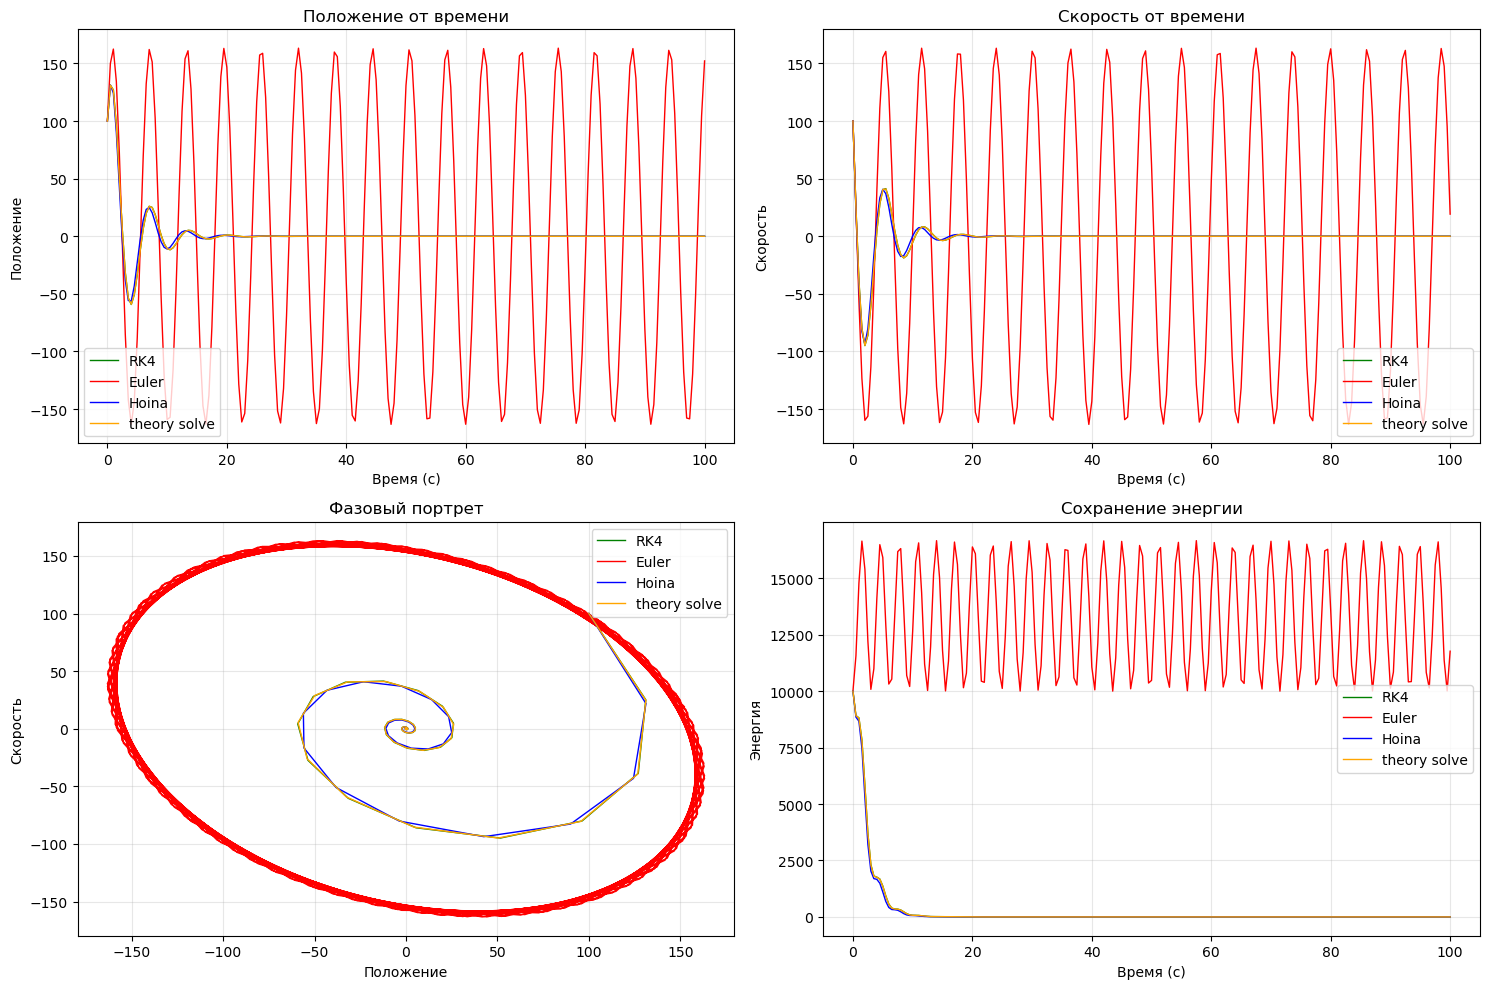

In [8]:
sim.compare_methods()